# Masking a DEM to the Upper Tuolumne River Watershed
***

Import libraries we'll use to read and write GeoTiff files, and plot figures.

In [1]:
import rasterio as rio
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot as plt

Open the DEM GeoTiff file using rasterio.

In [2]:
dem = rio.open('dem30m.tif')

We can inspect the file's metadata, which includes coordinate reference system (crs) and geographic transformation (transform) information which lets us plot the DEM as a map.

In [3]:
dem.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 1777,
 'height': 1684,
 'count': 1,
 'crs': CRS({'init': 'epsg:32611'}),
 'transform': Affine(29.999999999999705, 0.0, 254150.4675894332,
        0.0, -29.999999999999723, 4229820.934460746)}

We can also inspect individual items of the metadata like this:

In [5]:
dem.transform

Affine(29.999999999999705, 0.0, 254150.4675894332,
       0.0, -29.999999999999723, 4229820.934460746)

Our dem file has a band 'count' of 1. This contains the actual elevation values that we want to manipulate in order to mask areas outside of the watershed.

We can access this "band" and save it as an numpy array as follows:

In [6]:
elevation = dem.read(1)

What does this numpy array of elevations look like?

In [7]:
elevation

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

We can also plot this numpy array using matplotlib:

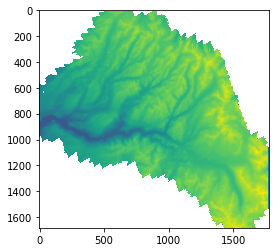

In [8]:
fig, ax = plt.subplots()
ax.imshow(elevation);

Note that the coordinates of the above image are "pixel coordinates" of just rows and columns, rather than geographic coordinates (lat, lon, or UTM).

Rasterio can plot our image using geographic coordinates since it will read the crs and transform from the file's metadata. (We also change the size of the figure using "figsize", set a minimum and maximum value for the colorscale (vmin, vmax), and change the color map using "cmap")

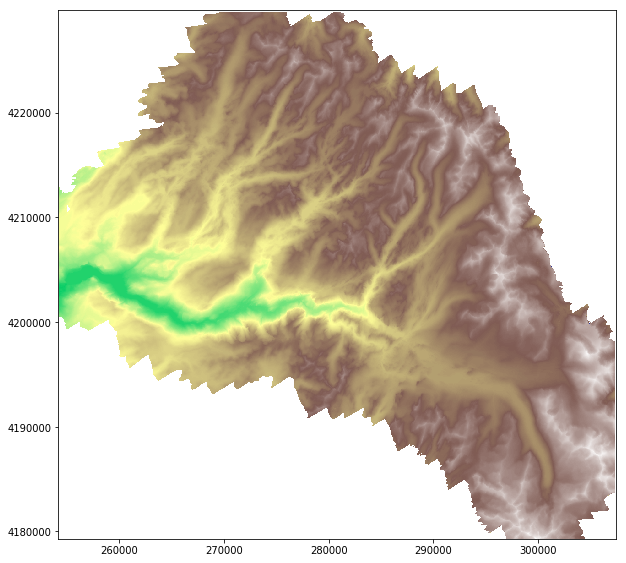

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
show(dem, vmin=0, vmax=4000, cmap='terrain');

Now let's open our mask file and inspect its contents:

In [10]:
mask = rio.open('scene_30m_mask.tif')
mask.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 1777,
 'height': 1684,
 'count': 1,
 'crs': CRS({'init': 'epsg:32611'}),
 'transform': Affine(29.999999999999705, 0.0, 254150.4675894332,
        0.0, -29.999999999999723, 4229820.934460746)}

Note that the crs is the same as our DEM GeoTiff file, therefore we don't need to reproject either dataset since they're already in the same projection.

We can plot this mask file on top of our DEM to see what areas are within the watershed that we want to keep:
(in the plot below, the area covered by the mask we will want to keep, and the area outside of the mask we will want to remove)

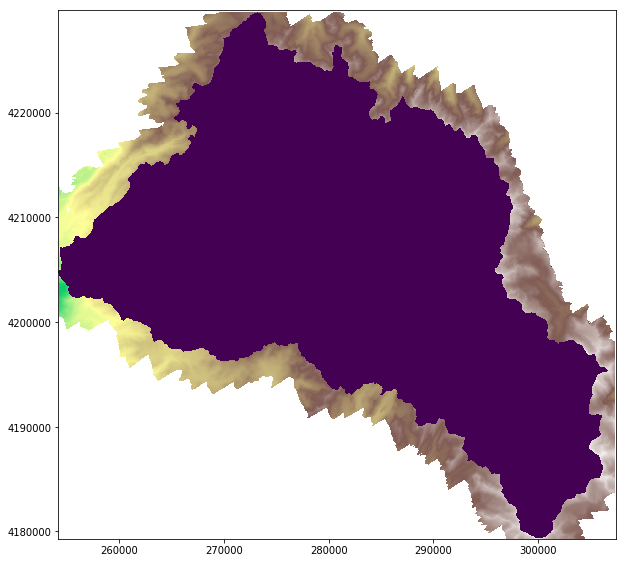

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
rio.plot.show(mask, ax=ax, zorder=1)
rio.plot.show(dem, vmin=0, vmax=4000, cmap='terrain', ax=ax, zorder=0);

Let's inspect the values of the mask array:

In [12]:
mask_array = mask.read(1)
mask_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

All we see here are 'nan' values at the corners, but what value is used to designate the watershed area?
We can look at the center pixel of the mask array to find this value (becuase we know the center of the array is inside the watershed)

To find the center pixel, we need the shape (number of rows and columns) of the array:

In [13]:
mask_array.shape

(1684, 1777)

In [14]:
n_rows = mask_array.shape[0]
n_cols = mask_array.shape[1]

print('Number of rows: ', n_rows)
print('Number of columns: ', n_cols)

Number of rows:  1684
Number of columns:  1777


Now we can find the center pixel by dividing the length of each dimensions (rows, columns) in half. We are also making sure that our values are integers (which will round our n_col/2 value since we have an odd number of columns).

Then use this center pixel row,column to find the center pixel's value through indexing:

In [15]:
center_row = int( n_rows / 2 )
center_column = int ( n_cols / 2 )

mask_array[center_row,center_column]

1.0

Now we can see that our mask has a value of 1 wherever a pixel is inside the watershed, and 'nan' when it is outside the watershed.

Multiplying a number by 'nan' will result in 'nan', whereas multiplying by 1 we will keep the original value. Therefore we can simply multiply our DEM (elevation) array with this mask array. Any DEM values outside of the watershed will now become 'nan' and values within the watershed will not be changed.

In [16]:
masked_elev = elevation * mask_array

Plot the original DEM next to the result of applying the mask to our DEM:

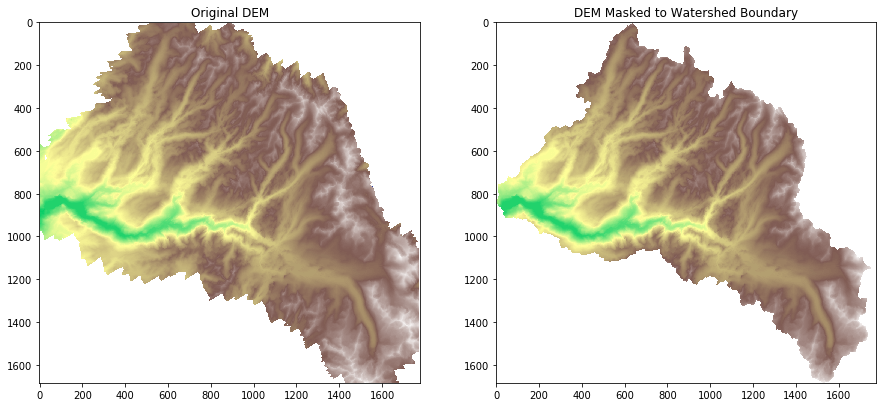

In [17]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(15,8))
ax1.imshow(elevation, vmin=0, vmax=4000, cmap='terrain');
ax1.set_title('Original DEM');
ax2.imshow(masked_elev, vmin=0, vmax=4000, cmap='terrain');
ax2.set_title('DEM Masked to Watershed Boundary');

Use rasterio to write a new GeoTiff file for te DEM that is masked to the watershed boundary.

We will use metadata from the original DEM file to specify the coordinate reference system, transform, and affine.

In [18]:
# Open and write to this new file
with rio.open('masked_dem30m.tif', 
              'w', 
              driver='GTiff',
              height=masked_elev.shape[0],
              width=masked_elev.shape[1],
              count=1, 
              dtype='float64',
              nodata=-9999,
              crs=dem.crs, 
              transform=dem.transform) as dst:

    dst.write(masked_elev, 1)

Read our new file back in to confirm that it worked!

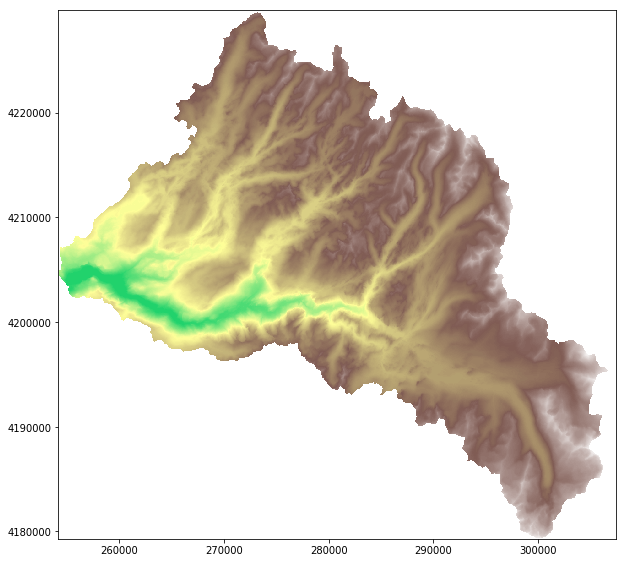

In [19]:
masked_dem = rio.open('masked_dem30m.tif')
fig, ax = plt.subplots(figsize=(10,10))
show(masked_dem, vmin=0, vmax=4000, cmap='terrain');

Looks good!